In [110]:
#packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [372]:
#dataset import
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
train_data.reset_index(drop=True, inplace=True)
validation_data = pd.read_csv("validation.csv")

# 1 Data Exploration

In [373]:
#Split the data by advertisers
#training set
ad_dict_train={}
ad_list_train=train_data.advertiser.unique()
for name in ad_list_train:
    ad_dict_train[name]=train_data[train_data.advertiser==name]
#The data for specific advertiser can be retrived by ad_dict[xxxx] with xxxx being the advertiser e.g. ad_dict[3427]

#extract os and browser info 
train_data['os']=train_data.useragent.apply(lambda x: x.split('_')[0])
train_data['browser']=train_data.useragent.apply(lambda x: x.split('_')[1])
#get slot size
train_data['slotsize']=train_data['slotwidth']*train_data['slotheight']
#get imps
train_data['imps']=0
train_data.loc[(train_data.bidprice>train_data.payprice),'imps'] = 1

In [496]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430981 entries, 0 to 2430980
Data columns (total 29 columns):
click             int64
weekday           int64
hour              int64
bidid             object
userid            object
useragent         object
IP                object
region            int64
city              int64
adexchange        float64
domain            object
url               object
urlid             float64
slotid            object
slotwidth         int64
slotheight        int64
slotvisibility    object
slotformat        object
slotprice         int64
creative          object
bidprice          int64
payprice          int64
keypage           object
advertiser        int64
usertag           object
os                object
browser           object
slotsize          int64
imps              int64
dtypes: float64(2), int64(13), object(14)
memory usage: 537.9+ MB


# 1.1 Basic Statistics

In [95]:
#get table for basic statistics
from tabulate import tabulate

def get_statistics(ad_dict):
    table=[]
    headers=["Adv", "Bids", "Imps", "Clicks",'Cost','CTR','CPM','eCPC']
    #calculation
    for ad in ad_dict:
        df=ad_dict[ad]
        bids=len(df)
        imps=len(df[df.bidprice>df.payprice])
        click=np.sum(df.click)
        cpm=np.mean(df.payprice)
        cost=imps*cpm/1000
        ctr=click/imps
        ecpc=cost/click
        #fill the statistics in the table
        row=[ad,bids,imps,click, int(cost),"%.3f%%" %(100*ctr),"%.2f" % (cpm),"%.2f" % (ecpc)]
        table.append(row)
    print(tabulate(table, headers, tablefmt="fancy_grid"))


In [96]:
get_statistics(ad_dict_train)

╒═══════╤════════╤════════╤══════════╤════════╤════════╤═══════╤════════╕
│   Adv │   Bids │   Imps │   Clicks │   Cost │ CTR    │   CPM │   eCPC │
╞═══════╪════════╪════════╪══════════╪════════╪════════╪═══════╪════════╡
│  3427 │ 402806 │ 402493 │      272 │  30435 │ 0.068% │ 75.62 │ 111.89 │
├───────┼────────┼────────┼──────────┼────────┼────────┼───────┼────────┤
│  2821 │ 211366 │ 211267 │      131 │  18819 │ 0.062% │ 89.08 │ 143.66 │
├───────┼────────┼────────┼──────────┼────────┼────────┼───────┼────────┤
│  1458 │ 492353 │ 491564 │      385 │  33914 │ 0.078% │ 68.99 │  88.09 │
├───────┼────────┼────────┼──────────┼────────┼────────┼───────┼────────┤
│  2259 │ 133673 │ 133615 │       43 │  12422 │ 0.032% │ 92.97 │ 288.9  │
├───────┼────────┼────────┼──────────┼────────┼────────┼───────┼────────┤
│  3386 │ 455041 │ 454390 │      320 │  34881 │ 0.070% │ 76.77 │ 109.01 │
├───────┼────────┼────────┼──────────┼────────┼────────┼───────┼────────┤
│  3358 │ 264956 │ 264349 │      202 │

# 1.2 User Feedback

In [ ]:
#split the data by features
def get_split_ctr(df,feature):
    f_list=sorted(df[feature].unique())
    f_mean=[]
    f_sample=[]
    f_se=[]
    f_se_all=[]
    for f in f_list:
        useful=df[df[feature]==f]        
        #exclude nan
        if sum(useful.imps!=0):
            ctr_mean=sum(useful.click)/sum(useful.imps)
            f_mean.append(ctr_mean)
            #split data into tenfold to get se
            df0,df1,df2,df3,df4=np.split(useful,[int(.2*len(df)), int(.2*len(df)), int(.2*len(df)), int(.2*len(df))])
            sample_list=[df0,df1,df2,df3,df4]
            for sample in sample_list:
                ctr=sum(useful.click)/sum(useful.imps)
                f_sample.append(ctr)
            f_se=np.std(f_sample)
            f_se_all.append(f_sample)
        else:
            f_list.remove(f)
        
    return f_mean,f_list,f_se,f_se_all

Text(0.5, 0, 'Slotsize')

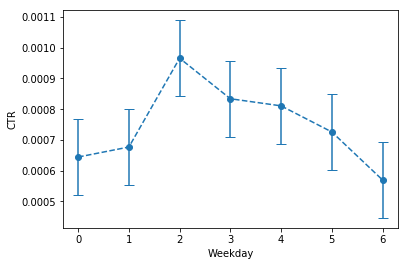

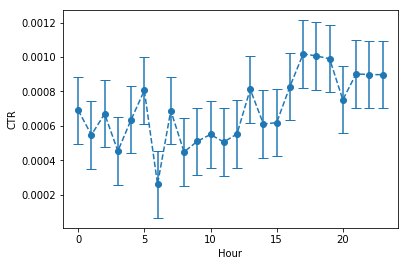

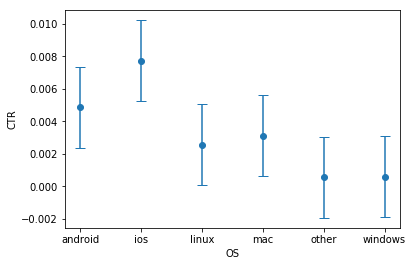

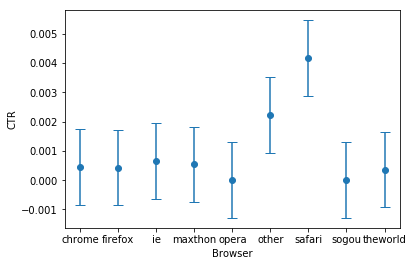

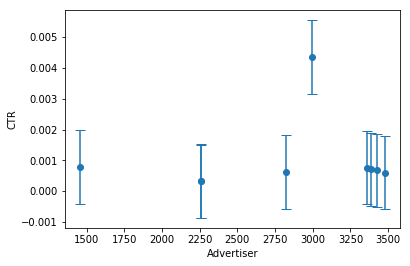

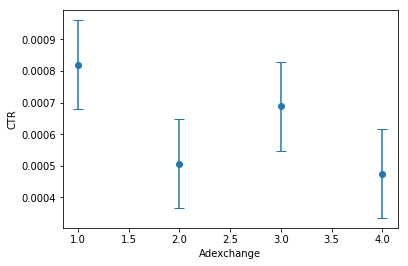

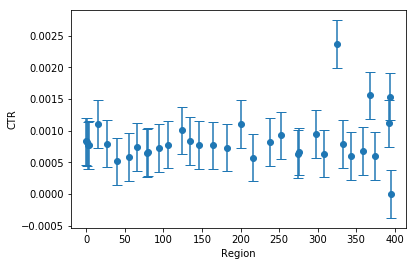

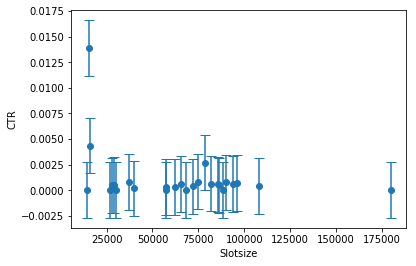

In [453]:
#CTR price against features: weekday, hour, os, browser, advertiser, adexchange, region, slotsize

fig, ax = plt.subplots()
wd_c=get_split_ctr(train_data,'weekday')
ax.errorbar(wd_c[1],wd_c[0],wd_c[2],fmt='o',linestyle='dashed',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Weekday')

fig, ax = plt.subplots()
hour_c=get_split_ctr(train_data,'hour')
ax.errorbar(hour_c[1],hour_c[0],yerr=hour_c[2],fmt='o',linestyle='dashed',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Hour')

fig, ax = plt.subplots()
os_c=get_split_ctr(train_data,'os')
ax.errorbar(os_c[1],os_c[0],yerr=os_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('OS')

fig, ax = plt.subplots()
br_c=get_split_ctr(train_data,'browser')
ax.errorbar(br_c[1],br_c[0],yerr=br_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Browser')

fig, ax = plt.subplots()
ad_c=get_split_ctr(train_data,'advertiser')
ax.errorbar(ad_c[1],ad_c[0],yerr=ad_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Advertiser')

fig, ax = plt.subplots()
adx_c=get_split_ctr(train_data,'adexchange')
ax.errorbar(adx_c[1],adx_c[0],yerr=adx_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Adexchange')

fig, ax = plt.subplots()
re_c=get_split_ctr(train_data,'region')
ax.errorbar(re_c[1],re_c[0],yerr=re_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Region')

fig, ax = plt.subplots()
sl_c=get_split_ctr(train_data,'slotsize')
ax.errorbar(sl_c[1],sl_c[0],yerr=sl_c[2],linestyle='None',fmt='o',capsize=5)
ax.set_ylabel("CTR")
ax.set_xlabel('Slotsize')

In [497]:
#sort and split the data by usertag
def get_usertag_ctr(df):
    df=df[df.usertag.notnull()]
    cate=df['usertag'].str.split(',')
    df['usertag_split']=cate
    unique_list=[]
    tag_dict=[]
    f_mean=[]
    f_sample=[]
    f_se=[]
    f_se_all=[]
    #get list of all unique usertag
    for item in cate:
        len_row=len(item)
        list_temp=[]
        for j in range(len_row):
            list_temp.append(item[j])
            for x in list_temp:
                if x not in unique_list:
                    unique_list.append(x)
    unique_list=sorted(unique_list)
    #split data by unique usertag
    for tag in unique_list:
        useful=df[df.usertag.apply(lambda x: tag in x)]
        ctr_mean=sum(useful.click)/sum(useful.imps)
        f_mean.append(ctr_mean)
        #split each data into tenfold to get se
        df0,df1,df2,df3,df4=np.split(useful,[int(.2*len(df)), int(.2*len(df)), int(.2*len(df)), int(.2*len(df))])
        sample_list=[df0,df1,df2,df3,df4]
        #get statistics
        for sample in sample_list:
            ctr=sum(useful.click)/sum(useful.imps)
            f_sample.append(ctr)
        f_se=np.std(f_sample)
        f_se_all.append(f_sample)

        
    return f_mean,unique_list,f_se,f_se_all


/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


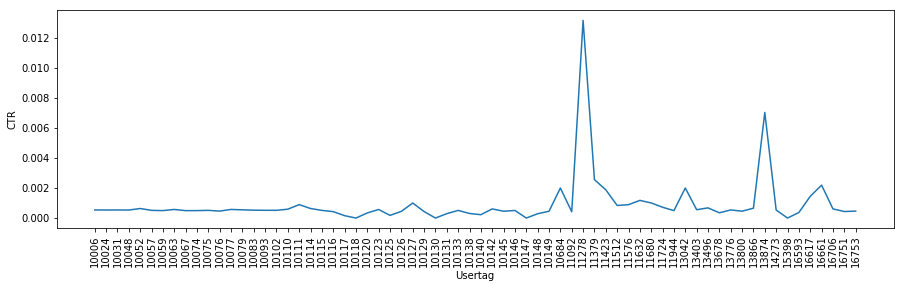

In [498]:
fig, ax = plt.subplots(figsize=(15,4))
ur_c=get_usertag_ctr(train_data)
ax.errorbar(ur_c[1],ur_c[0],fmt='-')
ax.set_ylabel("CTR")
ax.set_xlabel('Usertag')
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)

# 1.3 Bidding Behaviour

In [283]:
#get data for box plot
def get_split_data(df,feature,value):
    f_list=sorted(df[feature].unique())
    f_dict=[]
    for f in f_list:
        if str(f)=='nan':
            f_list.remove(f)
    for f in f_list:
        useful=df[df[feature]==f][value]
        f_dict.append(useful)
    return f_dict,f_list

Text(0.5, 0, 'Adexchange')

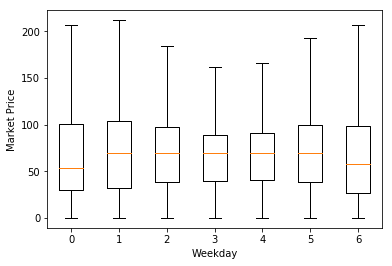

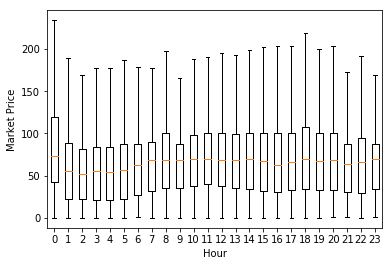

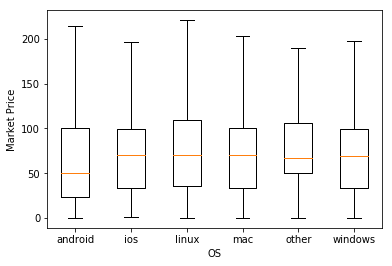

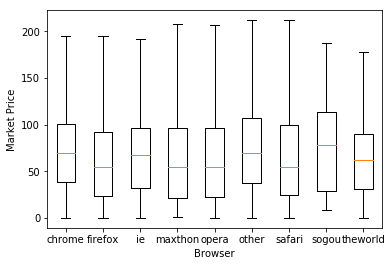

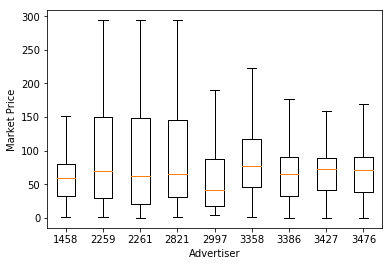

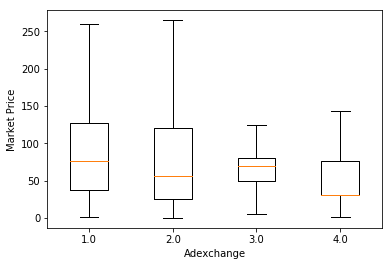

In [286]:
#market price against features: weekday, hour, os, browser, advertiser, adexchange

fig, ax = plt.subplots()
wd_p=get_split_data(train_data,'weekday','payprice')
ax.boxplot(wd_p[0],labels=wd_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Weekday')

fig, ax = plt.subplots()
hour_p=get_split_data(train_data,'hour','payprice')
ax.boxplot(hour_p[0],labels=hour_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Hour')

fig, ax = plt.subplots()
os_p=get_split_data(train_data,'os','payprice')
ax.boxplot(os_p[0],labels=os_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('OS')

fig, ax = plt.subplots()
br_p=get_split_data(train_data,'browser','payprice')
ax.boxplot(br_p[0],labels=br_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Browser')

fig, ax = plt.subplots()
ad_p=get_split_data(train_data,'advertiser','payprice')
ax.boxplot(ad_p[0],labels=ad_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Advertiser')

fig, ax = plt.subplots()
adx_p=get_split_data(train_data,'adexchange','payprice')
ax.boxplot(adx_p[0],labels=adx_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Adexchange')





Text(0.5, 0, 'Region')

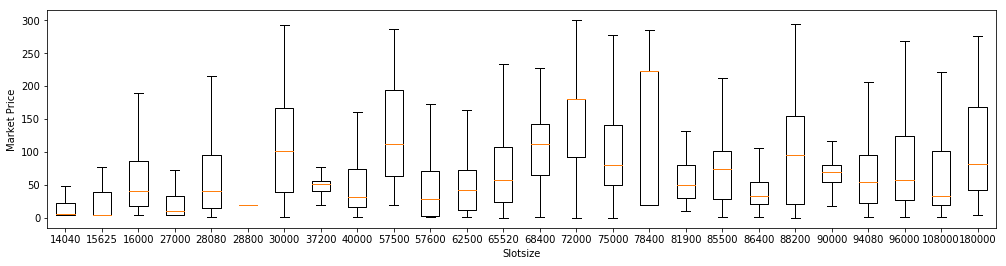

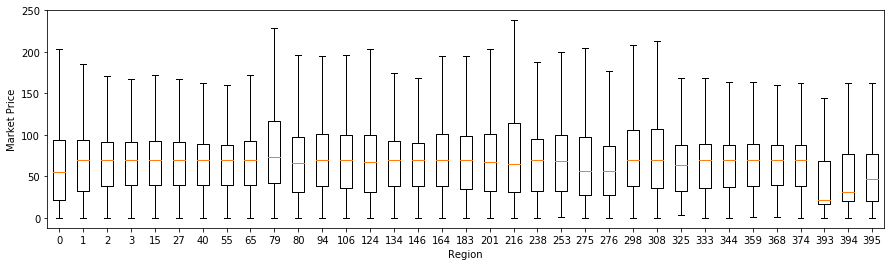

In [449]:
#market price against slotsize and region
fig, ax = plt.subplots(figsize=(17,4))
ss_p=get_split_data(train_data,'slotsize','payprice')
ax.boxplot(ss_p[0],labels=ss_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Slotsize')

fig, ax = plt.subplots(figsize=(15,4))
rg_p=get_split_data(train_data,'region','payprice')
ax.boxplot(rg_p[0],labels=rg_p[1],showfliers=False)
ax.set_ylabel("Market Price")
ax.set_xlabel('Region')


In [487]:
#sort and split the data by usertag
def get_usertag_data(df,value):
    df=df[df.usertag.notnull()]
    cate=df['usertag'].str.split(',')
    df['usertag_split']=cate
    unique_list=[]
    tag_dict=[]
    mean_list=[]
    for item in cate:
        len_row=len(item)
        list_temp=[]
        for j in range(len_row):
            list_temp.append(item[j])
            for x in list_temp:
                if x not in unique_list:
                    unique_list.append(x)
    unique_list=sorted(unique_list)
    for tag in unique_list:
        useful=df[df.usertag.apply(lambda x: tag in x)][value]
        tag_dict.append(useful) 
        mean_list.append(np.mean(useful))
    return tag_dict, unique_list, mean_list


    

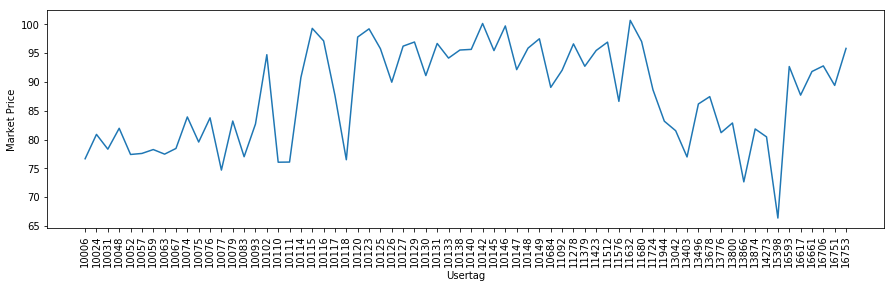

In [495]:
fig, ax = plt.subplots(figsize=(15,4))
ur_p=get_usertag_data(train_data,'payprice')
ax.errorbar(ur_p[1],ur_p[2],fmt='-')
ax.set_ylabel("Market Price")
ax.set_xlabel('Usertag')
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
